# SANS2D: I(Q) for sample and background

In this notebook, we will be reducing a sample and a background measurements to a one-dimensional $I(Q)$.

It assumes the detector data has been recorded in event mode, while the monitor data has been histogrammed.

The data used in this notebook has been published in [Manasi et al. (2021)](#manasi2021),
and we kindly thank the authors for allowing us to use their data.

**Outline:**

- We will begin by loading the data files containing the sample, direct, and background measurements.
- We will then apply some corrections to beamline components specific to the SANS2D beamline.
- This will be followed by some masking of some saturated or defect detector pixels
- Finally, the sample and background measurement will be converted to the $Q$ dimension

In [1]:
import matplotlib.pyplot as plt
import scipp as sc
from ess import loki, sans
from ess.logging import configure_workflow
import scippneutron as scn
import scippnexus.v2 as snx
from scippnexus.v2.application_definitions import nxcansas

In [2]:
logger = configure_workflow('sans2d_reduction', filename='sans2d.log')

## Define reduction workflow parameters

We define here whether to include the effects of gravity,
as well as common wavelength and $Q$ bins for all the measurements.

In [3]:
# Include effects of gravity?
gravity = True

# Wavelength binning
wavelength_bins = sc.linspace(
    dim='wavelength', start=2.0, stop=16.0, num=141, unit='angstrom'
)

# Q binning
q_bins = sc.linspace(dim='Q', start=0.01, stop=0.5, num=141, unit='1/angstrom')

## Loading data files

We load the following files:

- The direct beam function for the main detector (gives detector efficiency as a function of wavelength)
- The sample measurement
- The direct measurement: this is the run with the empty sample holder/cuvette
- The background measurement: this is the run with only the solvent which the sample is placed in

In [4]:
direct_beam = sc.io.load_hdf5(
    loki.data.get_path('DIRECT_SANS2D_REAR_34327_4m_8mm_16Feb16.hdf5')
)
sample = loki.io.load_sans2d(filename=loki.data.get_path('SANS2D00063114.hdf5'))
direct = loki.io.load_sans2d(filename=loki.data.get_path('SANS2D00063091.hdf5'))
background = loki.io.load_sans2d(filename=loki.data.get_path('SANS2D00063159.hdf5'))
dg = {'sample': sample, 'direct': direct, 'background': background}

## Pre-process monitor data

We convert the monitor data from time-of-flight to wavelength, remove background noise,
and rebin to the requested wavelength binning using the `preprocess_monitor_data` helper function from the `i_of_q` submodule:

In [5]:
monitors = {}
for key, da in dg.items():
    monitors[f'{key}-incident'] = da.attrs["monitor2"].value
    monitors[f'{key}-transmission'] = da.attrs["monitor4"].value

# Define range outside of which monitor data is considered to be background
non_background_range = sc.array(
    dims=['wavelength'], values=[0.7, 17.1], unit='angstrom'
)

# Run preprocessing
monitors = sans.i_of_q.preprocess_monitor_data(
    monitors, non_background_range=non_background_range, wavelength_bins=wavelength_bins
)

# Unpack monitors to make steps below easier
sample_monitors = {
    'incident': monitors['sample-incident'],
    'transmission': monitors['sample-transmission'],
}
direct_monitors = {
    'incident': monitors['direct-incident'],
    'transmission': monitors['direct-transmission'],
}
background_monitors = {
    'incident': monitors['background-incident'],
    'transmission': monitors['background-transmission'],
}

## Masking bad detector pixels

**Note:** We use programmatic masks here and not those stored in xml files.

Now that the monitor data is cleaned and binned to the correct wavelength range, we turn to the detector data.
The first step is to mask noisy and saturated pixels.
We mask the edges of the square-shaped detector panel with a simple distance relation.
We also mask the region close to the beam center,
where the sample holder is visible as a dark patch with an arm extending to the north-east.

In [6]:
mask_edges = (
    sc.abs(sample.coords['position'].fields.x) > sc.scalar(0.48, unit='m')
) | (sc.abs(sample.coords['position'].fields.y) > sc.scalar(0.45, unit='m'))

summed = sample.sum('tof')
holder_mask = (
    (summed.data < sc.scalar(100, unit='counts'))
    & (sample.coords['position'].fields.x > sc.scalar(0, unit='m'))
    & (sample.coords['position'].fields.x < sc.scalar(0.42, unit='m'))
    & (sample.coords['position'].fields.y < sc.scalar(0.05, unit='m'))
    & (sample.coords['position'].fields.y > sc.scalar(-0.15, unit='m'))
)

for da in dg.values():
    da.masks['edges'] = mask_edges
    da.masks['holder_mask'] = holder_mask

A good sanity check is to view the masks on the instrument view:

In [7]:
scn.instrument_view(sample.hist(), pixel_size=0.0075)

Box(children=(Figure(children=(HBar(children=(HTML(value=''),)), HBox(children=(VBar(children=(Toolbar(childre‚Ä¶

### Beam center finder

The beam is not guaranteed to travel through the center of the detector panel,
and we thus have to apply a horizontal and vertical offset to our pixel positions so that the beam centre is at `x = y = 0`.
This is necessary for subsequent azimuthal averaging of the data counts into $Q$ bins.

The `beam_center` utility in the `sans` module is designed for this.
It requires us to define a $Q$ range over which convergence will be checked.

In [8]:
q_range = sc.linspace('Q', 0.02, 0.3, 71, unit='1/angstrom')

center = sans.beam_center(
    data=dg['sample'],
    data_monitors=sample_monitors,
    direct_monitors=direct_monitors,
    wavelength_bins=wavelength_bins,
    q_bins=q_range,
    gravity=gravity,
)

print(center)

# Now shift pixels positions to get the correct beam center
for da in dg.values():
    da.coords['position'] -= center

<scipp.Variable> ()    vector3              [m]  (0.0945643, -0.082074, 0)


## Mask Bragg peaks in wavelength

We will now take out the time regions with Bragg peaks from the beam stop and detector window,
although in reality the peaks appear only close to the beam stop,
and will make little difference to $I(Q)$.

This could be implemented as masking specific time bins for a specific region in space,
but for now we keep it simple.

In [9]:
wavelength_mask = sc.DataArray(
    data=sc.array(dims=['wavelength'], values=[True]),
    coords={
        'wavelength': sc.array(
            dims=['wavelength'], values=[2.21, 2.59], unit='angstrom'
        )
    },
)

## Use to_I_of_Q workflow

We now reduce the sample and the background measurements to `Q` using the `sans.to_I_of_Q` workflow.

In that process,
the intensity as a function of `Q` is normalized using the direct measurement and direct beam function.

We call the workflow on both the sample and background runs:

[2023-08-08T12:24:19+0200] WARNING  <scipp.ess.sans> : 
    An interpolation was performed on the direct_beam function. The variances in the direct_beam function have been dropped.


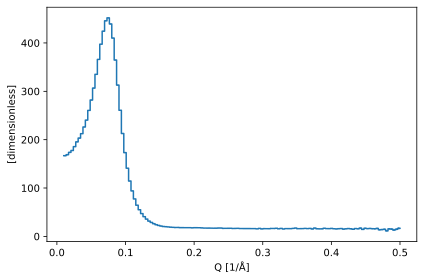

In [10]:
sample_q = sans.to_I_of_Q(
    data=dg['sample'],
    data_monitors=sample_monitors,
    direct_monitors=direct_monitors,
    direct_beam=direct_beam,
    wavelength_bins=wavelength_bins,
    q_bins=q_bins,
    gravity=gravity,
    wavelength_mask=wavelength_mask,
)
sample_q.hist().plot()

[2023-08-08T12:24:20+0200] WARNING  <scipp.ess.sans> : 
    An interpolation was performed on the direct_beam function. The variances in the direct_beam function have been dropped.


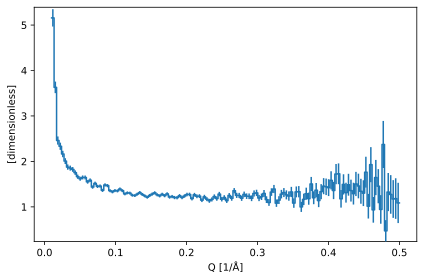

In [11]:
background_q = sans.to_I_of_Q(
    data=dg['background'],
    data_monitors=background_monitors,
    direct_monitors=direct_monitors,
    direct_beam=direct_beam,
    wavelength_bins=wavelength_bins,
    q_bins=q_bins,
    gravity=gravity,
    wavelength_mask=wavelength_mask,
)
background_q.hist().plot()

We are now in a position to subtract the background from the sample measurement:

In [12]:
result = sample_q.bins.sum() - background_q.bins.sum()
result

<scipp.DataArray>
Dimensions: Sizes[Q:140, ]
Coordinates:
  L1                        float64              [m]  ()  19.334
* Q                         float64           [1/√Ö]  (Q [bin-edge])  [0.01, 0.0135, ..., 0.4965, 0.5]
  gravity                   vector3          [m/s^2]  ()  (0, -9.80665, 0)
  incident_beam             vector3              [m]  ()  (0, 0, 19.334)
* pixel_height              float64              [m]  ()  0.00203398
* pixel_width               float64              [m]  ()  0.0035
  sample_position           vector3              [m]  ()  (0, 0, 19.334)
  source_position           vector3              [m]  ()  (0, 0, 0)
  wavelength                float64             [√Ö]  (wavelength [bin-edge])  [2, 16]
Data:
                            float32  [dimensionless]  (Q)  [161.784, 165.3, ..., 13.4768, 15.5177]  [1.75832, 1.08763, ..., 3.22596, 3.87254]
Attributes:
  current_period              int64  [dimensionless]  ()  1
  experiment_identifier      string  [dimensionless]  ()  "1920676"
  instrument_name            string        <no unit>  ()  "SANS2D"
  measurement_id             string  [dimensionless]  ()  ""
  measurement_label          string  [dimensionless]  ()  ""
  measurement_subid          string  [dimensionless]  ()  ""
  measurement_type           string  [dimensionless]  ()  ""
  nperiods                    int64  [dimensionless]  ()  1
  placeholder monitor_5   DataArray        <no unit>  ()  DataArray(dims=(tof: 481), dtype=float64, unit=counts)
  placeholder monitor_6   DataArray        <no unit>  ()  DataArray(dims=(tof: 481), dtype=float64, unit=counts)
  placeholder monitor_7   DataArray        <no unit>  ()  DataArray(dims=(tof: 481), dtype=float64, unit=counts)
  placeholder monitor_8   DataArray        <no unit>  ()  DataArray(dims=(tof: 481), dtype=float64, unit=counts)

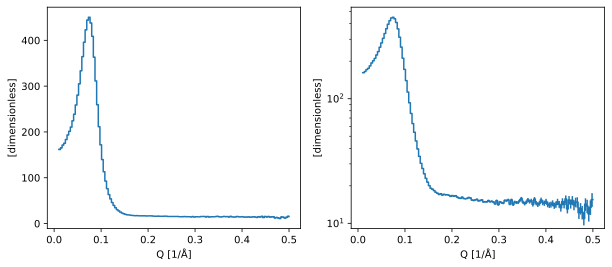

In [13]:
fig1, ax1 = plt.subplots(1, 2, figsize=(10, 4))
sc.plot(result, ax=ax1[0])
sc.plot(result, norm='log', ax=ax1[1])

<div class="alert alert-info">

**Note**

Instead of `.bins.sum()`,
one could use `sc.histogram()` above to define different `Q` bins compared to the ones defined at the top of the notebook.
This can be done in event mode, see [here](https://scipp.github.io/user-guide/binned-data/computation.html#Subtraction).

There may be performance advantages to first use a coarse `Q` binning when the computing `I(Q)` numerator,
and use finer binning for the final results.

</div>

## Wavelength bands

It is often useful to process the data in a small number (~10) of separate wavelength bands.

This can be achieved by requesting 10 bands from the `to_I_of_Q` workflow via the `wavelength_bands` argument.

In [14]:
wavelength_bands = sc.linspace(
    dim='wavelength', start=2.0, stop=16.0, num=11, unit='angstrom'
)

sample_slices = sans.to_I_of_Q(
    data=dg['sample'],
    data_monitors=sample_monitors,
    direct_monitors=direct_monitors,
    direct_beam=direct_beam,
    wavelength_bins=wavelength_bins,
    q_bins=q_bins,
    gravity=gravity,
    wavelength_bands=wavelength_bands,
    wavelength_mask=wavelength_mask,
)

background_slices = sans.to_I_of_Q(
    data=dg['background'],
    data_monitors=background_monitors,
    direct_monitors=direct_monitors,
    direct_beam=direct_beam,
    wavelength_bins=wavelength_bins,
    q_bins=q_bins,
    gravity=gravity,
    wavelength_bands=wavelength_bands,
    wavelength_mask=wavelength_mask,
)

result_slices = sample_slices.bins.sum() - background_slices.bins.sum()
result_slices

[2023-08-08T12:24:21+0200] WARNING  <scipp.ess.sans> : 
    An interpolation was performed on the direct_beam function. The variances in the direct_beam function have been dropped.
[2023-08-08T12:24:22+0200] WARNING  <scipp.ess.sans> : 
    An interpolation was performed on the direct_beam function. The variances in the direct_beam function have been dropped.


<scipp.DataArray>
Dimensions: Sizes[Q:140, wavelength:10, ]
Coordinates:
  L1                        float64              [m]  ()  19.334
* Q                         float64           [1/√Ö]  (Q [bin-edge])  [0.01, 0.0135, ..., 0.4965, 0.5]
  gravity                   vector3          [m/s^2]  ()  (0, -9.80665, 0)
  incident_beam             vector3              [m]  ()  (0, 0, 19.334)
* pixel_height              float64              [m]  ()  0.00203398
* pixel_width               float64              [m]  ()  0.0035
  sample_position           vector3              [m]  ()  (0, 0, 19.334)
  source_position           vector3              [m]  ()  (0, 0, 0)
* wavelength                float64             [√Ö]  (wavelength [bin-edge])  [2, 3.4, ..., 14.6, 16]
Data:
                            float32  [dimensionless]  (Q, wavelength)  [95.5979, 129.736, ..., 0, 0]  [277.886, 10.2856, ..., 0, 0]
Attributes:
  current_period              int64  [dimensionless]  ()  1
  experiment_identifier      string  [dimensionless]  ()  "1920676"
  instrument_name            string        <no unit>  ()  "SANS2D"
  measurement_id             string  [dimensionless]  ()  ""
  measurement_label          string  [dimensionless]  ()  ""
  measurement_subid          string  [dimensionless]  ()  ""
  measurement_type           string  [dimensionless]  ()  ""
  nperiods                    int64  [dimensionless]  ()  1
  placeholder monitor_5   DataArray        <no unit>  ()  DataArray(dims=(tof: 481), dtype=float64, unit=counts)
  placeholder monitor_6   DataArray        <no unit>  ()  DataArray(dims=(tof: 481), dtype=float64, unit=counts)
  placeholder monitor_7   DataArray        <no unit>  ()  DataArray(dims=(tof: 481), dtype=float64, unit=counts)
  placeholder monitor_8   DataArray        <no unit>  ()  DataArray(dims=(tof: 481), dtype=float64, unit=counts)

/Users/wojciechpotrzebowski/miniconda3/envs/ess-mantid/lib/python3.8/site-packages/matplotlib/axes/_axes.py:3642: RuntimeWarning: invalid value encountered in add
  low, high = dep + np.row_stack([-(1 - lolims), 1 - uplims]) * err


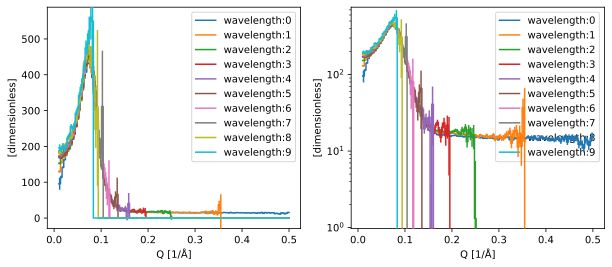

In [15]:
collapsed = sc.collapse(result_slices, keep='Q')

fig2, ax2 = plt.subplots(1, 2, figsize=(10, 4))
sc.plot(collapsed, ax=ax2[0])
sc.plot(collapsed, norm='log', ax=ax2[1])

## Saving reduced data to file
Finally, we can save reduced data to the file. Below there is an example of saving data for full range into NXcanSAS format (NeXus compatible) 

In [16]:
result.coords['Q'] = sc.midpoints(result.coords['Q'])

with snx.File('test.nxs', 'w') as f:
    f['sasentry'] = nxcansas.SASentry(title='Reduced data', run=12345)
    f['sasentry']['sasdata'] = nxcansas.SASdata(result, Q_variances='resolutions')

## References

<div id="manasi2021"></div>

Manasi I., Andalibi M. R., Atri R. S., Hooton J., King S. M., Edler K. J., **2021**,
*Self-assembly of ionic and non-ionic surfactants in type IV cerium nitrate and urea based deep eutectic solvent*,
[J. Chem. Phys. 155, 084902](https://doi.org/10.1063/5.0059238)